In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from IPython.display import Markdown, display

torch.set_grad_enabled(False)

from shared_definitions import *
from shared_visualization_utils import *

sys.path.insert(0, os.path.abspath(".."))

sns.set_theme(style="white", context="notebook", rc={"figure.figsize": (14, 10)})


In [3]:
result_df, indirect_effects_by_model_and_dataset, top_heads_by_model_and_dataset = load_and_combine_raw_results()
result_df.head()

2025-05-13 22:27:25.490 | INFO     | shared_definitions:load_and_combine_raw_results:416 - Loading cached results from data/full_results.pkl.gz


model                   dataset  top_n_prompt_acc  \
0  Llama-3.2-1B-Instruct         choose_first_of_3          0.767429   
1  Llama-3.2-1B-Instruct   capitalize_first_letter          0.936907   
2  Llama-3.2-1B-Instruct  capitalize_second_letter          0.110364   
3  Llama-3.2-1B-Instruct            english-french          0.663200   
4  Llama-3.2-1B-Instruct         choose_first_of_5          0.737286   

   top_1_prompt_acc                                      top_n_prompts  \
0          0.888571  [Extract the first token, Output the word at t...   
1          0.963093  [What is the initial letter of this word?, Det...   
2          0.160000  [What's the special letter in this word?, Dete...   
3          0.678224  [English word in French, English word to Frenc...   
4          0.772857  [Find the starting word of the input sequence,...   

   0_shot_acc  1_shot_acc  2_shot_acc  3_shot_acc  4_shot_acc  ...  \
0    0.636667    0.863333    0.896667    0.896667    0.913333  ...   
1    0.000000    0.688525    0.852459    0.918033    0.950820  ...   
2         NaN         NaN         NaN         NaN         NaN  ...   
3    0.011348    0.352482    0.587234    0.662411    0.687943  ...   
4    0.616667    0.810000    0.870000    0.890000    0.940000  ...   

   zs_universal_10_heads_max_acc_layer  zs_universal_20_heads_by_layer_acc  \
0                                  NaN                                 NaN   
1                                  NaN                                 NaN   
2                                  NaN                                 NaN   
3                                  NaN                                 NaN   
4                                  NaN                                 NaN   

   zs_universal_20_heads_max_acc  zs_universal_20_heads_max_acc_layer  \
0                            NaN                                  NaN   
1                            NaN                                  NaN   
2                            NaN                                  NaN   
3                            NaN                                  NaN   
4                            NaN                                  NaN   

   fs_shuffled_universal_40_heads_by_layer_acc  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   

   fs_shuffled_universal_40_heads_max_acc  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

   fs_shuffled_universal_40_heads_max_acc_layer  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

  zs_universal_40_heads_by_layer_acc  zs_universal_40_heads_max_acc  \
0                                NaN                            NaN   
1                                NaN                            NaN   
2                                NaN                            NaN   
3                                NaN                            NaN   
4                                NaN                            NaN   

   zs_universal_40_heads_max_acc_layer  
0                                  NaN  
1                                  NaN  
2                                  NaN  
3                                  NaN  
4                                  NaN  

[5 rows x 256 columns]

In [4]:
# only ran this on the 3.2 models so far:
result_df = result_df[result_df.model.str.contains(r"3\.\d")]
indirect_effects_by_model_and_dataset = {k: v for k, v in indirect_effects_by_model_and_dataset.items() if "3." in k}
top_heads_by_model_and_dataset = {k: v for k, v in top_heads_by_model_and_dataset.items() if "3." in k}

RELEVANT_MODELS = [model for model in ORDERED_MODELS if "3." in model]

# RQ 4.5: What do we learn from from the control experiments?

- Adding the FVs twice
- Using the "min abs" heads
- Using the worst heads


In [5]:
PLOT_SEM = True  # True for SEM, False for STD, None for neither
USE_ONE_THIRD_LAYER = True
LAYER_PLOT_SUFFIX = "one_third_layer" if USE_ONE_THIRD_LAYER else "max_acc_layer"

result_with_same_layer_localizers_controls_df = add_same_layer_results(
    result_df,
    special_type=None,
    include_icl=True,
    use_both_zs_and_fs_for_top_layer=True,
    use_one_third_layer_rule=USE_ONE_THIRD_LAYER,
)

MISSING_DATASETS_BY_MODEL = {}
n_top_heads = 10

for model in RELEVANT_MODELS:
    model_missing_datasets = set()
    for prompt_type in (SHORT, LONG, ICL):
        model_df = result_with_same_layer_localizers_controls_df[
            (result_with_same_layer_localizers_controls_df.model == model)
            & (result_with_same_layer_localizers_controls_df.prompt_type == prompt_type)
        ]

        zs_prefix = get_zs_prefix(True)
        universal_layer_acc_key = f"{zs_prefix}_{n_top_heads}_heads_universal_FV_acc"
        missing_datasets = model_df[model_df[universal_layer_acc_key].isna()].dataset.unique()
        model_missing_datasets.update(missing_datasets)

    MISSING_DATASETS_BY_MODEL[model] = model_missing_datasets


for special_type in SPECIAL_RESULT_TYPES:
    if special_type == "instruct_model":
        continue
    result_with_same_layer_localizers_controls_df = add_same_layer_results(
        result_with_same_layer_localizers_controls_df,
        special_type=special_type,
        include_icl=False,
        use_both_zs_and_fs_for_top_layer=True,
        use_one_third_layer_rule=USE_ONE_THIRD_LAYER,
    )


row_filter = result_with_same_layer_localizers_controls_df.apply(
    lambda row: row.dataset not in MISSING_DATASETS_BY_MODEL[row.model], axis=1
)

matched_datasets_result_with_same_layer_localizers_controls_df = result_with_same_layer_localizers_controls_df[
    row_filter
].copy(deep=True)


2025-05-13 22:27:26.959 | WARNING  | shared_definitions:row_to_same_layer_acc:630 - No data for Llama-3.2-1B-Instruct | capitalize_second_letter  | short | fs_shuffled_universal_both_all_10_heads_by_layer_acc
2025-05-13 22:27:26.960 | WARNING  | shared_definitions:row_to_same_layer_acc:630 - No data for Llama-3.2-1B-Instruct | lowercase_last_letter  | short | fs_shuffled_universal_both_all_10_heads_by_layer_acc
2025-05-13 22:27:26.961 | WARNING  | shared_definitions:row_to_same_layer_acc:630 - No data for Llama-3.2-1B-Instruct | lowercase_first_letter  | short | fs_shuffled_universal_both_all_10_heads_by_layer_acc
2025-05-13 22:27:26.962 | WARNING  | shared_definitions:row_to_same_layer_acc:630 - No data for Llama-3.2-1B-Instruct | next_capital_letter  | short | fs_shuffled_universal_both_all_10_heads_by_layer_acc
2025-05-13 22:27:26.964 | WARNING  | shared_definitions:row_to_same_layer_acc:630 - No data for Llama-3.2-3B | capitalize_second_letter  | short | fs_shuffled_universal_both_

In [6]:
summary_columns = [
    "10_shot_acc",
    "top_1_prompt_acc",
    "top_n_prompt_acc",
    "0_shot_acc",
]

summary_columns_shuffled_10_shot = [
    "10_shot_acc",
    "top_1_prompt_acc",
    "top_n_prompt_acc",
    "shuffled_10_shot_acc",
]

for nh in (10, 20):
    for columns, eval_type in ((summary_columns, "zs"), (summary_columns_shuffled_10_shot, "fs_shuffled")):
        columns.append(f"{eval_type}_universal_both_all_{nh}_heads_same_layer_acc")
        columns.append(f"{eval_type}_universal_icl_all_{nh}_heads_same_layer_acc")
        columns.extend(
            [
                f"{eval_type}_universal_both_{special_type}_all_{nh}_heads_same_layer_acc"
                for special_type in SPECIAL_RESULT_TYPES
                if special_type != "instruct_model"
            ]
        )


summary_layer_columns = [
    "zs_both_10_max_acc_layer",
    "zs_both_10_max_acc_layer_depth",
    "zs_icl_10_max_acc_layer",
    "zs_icl_10_max_acc_layer_depth",
    "zs_both_joint_intervention_10_max_acc_layer",
    "zs_both_joint_intervention_10_max_acc_layer_depth",
    "zs_both_prompt_fv_twice_10_max_acc_layer",
    "zs_both_prompt_fv_twice_10_max_acc_layer_depth",
    "zs_both_icl_fv_twice_10_max_acc_layer",
    "zs_both_icl_fv_twice_10_max_acc_layer_depth",
    "zs_both_20_max_acc_layer",
    "zs_both_20_max_acc_layer_depth",
    "zs_icl_20_max_acc_layer",
    "zs_icl_20_max_acc_layer_depth",
    "zs_both_joint_intervention_20_max_acc_layer",
    "zs_both_joint_intervention_20_max_acc_layer_depth",
    "zs_both_prompt_fv_twice_20_max_acc_layer",
    "zs_both_prompt_fv_twice_20_max_acc_layer_depth",
    "zs_both_icl_fv_twice_20_max_acc_layer",
    "zs_both_icl_fv_twice_20_max_acc_layer_depth",
]


display(Markdown("## Summary (aggregated by model) - 0-shot"))
localizers_controls_zero_shot_metric_dicts = print_summary(
    matched_datasets_result_with_same_layer_localizers_controls_df,
    summary_columns,
    [4, 15],
    use_sem=PLOT_SEM,
)
display(Markdown("## Summary (aggregated by model) - Shuffled 10-shot"))
localizers_controls_shuffled_ten_shot_metric_dicts = print_summary(
    matched_datasets_result_with_same_layer_localizers_controls_df,
    summary_columns_shuffled_10_shot,
    [4, 15],
    use_sem=PLOT_SEM,
)
display(Markdown("## Layer Summary (aggregated by model)"))
layer_depth_metric_dicts = print_summary(
    matched_datasets_result_with_same_layer_localizers_controls_df,
    summary_layer_columns,
    [
        10,
    ],
    agg="first",
)


localizers_controls_zero_shot_model_dicts = defaultdict(dict)
for metric_dict in localizers_controls_zero_shot_metric_dicts:
    metric_dict = {**metric_dict}
    metric = metric_dict.pop("metric")
    for model, value in metric_dict.items():
        localizers_controls_zero_shot_model_dicts[model][metric] = value


localizers_controls_shuffled_ten_shot_model_dicts = defaultdict(dict)
for metric_dict in localizers_controls_shuffled_ten_shot_metric_dicts:
    metric_dict = {**metric_dict}
    metric = metric_dict.pop("metric")
    for model, value in metric_dict.items():
        localizers_controls_shuffled_ten_shot_model_dicts[model][metric] = value


combined_model_dicts = {
    model: {**zs_model_dict, **localizers_controls_shuffled_ten_shot_model_dicts[model]}
    for model, zs_model_dict in localizers_controls_zero_shot_model_dicts.items()
}

## Summary (aggregated by model) - 0-shot

| metric                                      | Llama-3.2-1B    | Llama-3.2-1B-Instruct   | Llama-3.2-3B    | Llama-3.2-3B-Instruct   | Llama-3.1-8B    | Llama-3.1-8B-Instruct   | mean (no 13b)   |
|---------------------------------------------|-----------------|-------------------------|-----------------|-------------------------|-----------------|-------------------------|-----------------|
| 10-shot                                     | 0.6562 ± 0.0211 | 0.6930 ± 0.0191         | 0.7531 ± 0.0205 | 0.7895 ± 0.0173         | 0.8207 ± 0.0179 | 0.8456 ± 0.0171         | 0.7597 ± 0.0188 |
| Top-1 prompt                                | 0.6281 ± 0.0246 | 0.7164 ± 0.0226         | 0.7654 ± 0.0225 | 0.8638 ± 0.0172         | 0.8200 ± 0.0208 | 0.8874 ± 0.0159         | 0.7802 ± 0.0206 |
| Top-5 prompts (mean)                        | 0.5484 ± 0.0241 | 0.6598 ± 0.0225         | 0.7105 ± 0.0227 | 0.8330 ± 0.0184         | 0.7668 ± 0.0225 | 0.8507 ± 0.0185         | 0.7282 ± 0.0214 |
| 0-shot                                      | 0.1779 ± 0.0169 | 0.1566 ± 0.0136         | 0.1530 ± 0.0163 | 0.1066 ± 0.0088         | 0.1283 ± 0.0122 | 0.0772 ± 0.0071         | 0.1333 ± 0.0125 |
|  |
| Prompt FV 0-shot (10 heads)                 | 0.3041 ± 0.0297 | 0.3773 ± 0.0247         | 0.2872 ± 0.0271 | 0.3713 ± 0.0264         | 0.2659 ± 0.0218 | 0.4435 ± 0.0299         | 0.3416 ± 0.0266 |
| ICL FV 0-shot (10 heads)                    | 0.2781 ± 0.0324 | 0.3621 ± 0.0354         | 0.3158 ± 0.0318 | 0.4013 ± 0.0339         | 0.4057 ± 0.0354 | 0.4377 ± 0.0337         | 0.3668 ± 0.0338 |
| Joint FV 0-shot (10 heads)                  | 0.6104 ± 0.0302 | 0.6749 ± 0.0280         | 0.6282 ± 0.0296 | 0.6184 ± 0.0308         | 0.5542 ± 0.0319 | 0.6703 ± 0.0272         | 0.6261 ± 0.0296 |
| ICL activations FV 0-shot (10 heads)        | 0.2832 ± 0.0295 | 0.2813 ± 0.0234         | 0.2363 ± 0.0279 | 0.3257 ± 0.0236         | 0.2288 ± 0.0197 | 0.3538 ± 0.0293         | 0.2849 ± 0.0256 |
| ICL top heads FV 0-shot (10 heads)          | 0.2910 ± 0.0294 | 0.2644 ± 0.0237         | 0.2060 ± 0.0241 | 0.1745 ± 0.0157         | 0.1870 ± 0.0207 | 0.1191 ± 0.0122         | 0.2070 ± 0.0210 |
| Prompt FV twice FV 0-shot (10 heads)        | 0.3337 ± 0.0296 | 0.2486 ± 0.0267         | 0.2058 ± 0.0285 | 0.5854 ± 0.0306         | 0.4542 ± 0.0294 | 0.6380 ± 0.0269         | 0.4109 ± 0.0286 |
| ICL FV twice FV 0-shot (10 heads)           | 0.6616 ± 0.0316 | 0.6212 ± 0.0309         | 0.6568 ± 0.0277 | 0.6306 ± 0.0307         | 0.6452 ± 0.0296 | 0.6250 ± 0.0300         | 0.6401 ± 0.0301 |
| Prompt least imp heads FV 0-shot (10 heads) | 0.2799 ± 0.0298 | 0.2466 ± 0.0245         | 0.1867 ± 0.0229 | 0.1098 ± 0.0106         | 0.1573 ± 0.0175 | 0.0670 ± 0.0087         | 0.1745 ± 0.0190 |
| ICL least imp heads FV 0-shot (10 heads)    | 0.2800 ± 0.0298 | 0.2396 ± 0.0246         | 0.1860 ± 0.0227 | 0.1125 ± 0.0107         | 0.1573 ± 0.0175 | 0.0677 ± 0.0087         | 0.1739 ± 0.0190 |
| Prompt bottom heads FV 0-shot (10 heads)    | 0.2754 ± 0.0291 | 0.1121 ± 0.0169         | 0.1593 ± 0.0206 | 0.0652 ± 0.0088         | 0.1045 ± 0.0132 | 0.0245 ± 0.0054         | 0.1235 ± 0.0157 |
| ICL bottom heads FV 0-shot (10 heads)       | 0.2653 ± 0.0288 | 0.1658 ± 0.0204         | 0.1609 ± 0.0212 | 0.0542 ± 0.0076         | 0.1090 ± 0.0145 | 0.0151 ± 0.0050         | 0.1284 ± 0.0163 |
|  |
| Prompt FV 0-shot (20 heads)                 | 0.3947 ± 0.0316 | 0.4429 ± 0.0272         | 0.4550 ± 0.0329 | 0.5546 ± 0.0277         | 0.2321 ± 0.0254 | 0.5753 ± 0.0276         | 0.4424 ± 0.0287 |
| ICL FV 0-shot (20 heads)                    | 0.3274 ± 0.0357 | 0.4294 ± 0.0358         | 0.3770 ± 0.0344 | 0.4823 ± 0.0384         | 0.4938 ± 0.0394 | 0.4816 ± 0.0411         | 0.4319 ± 0.0375 |
| Joint FV 0-shot (20 heads)                  | 0.7306 ± 0.0283 | 0.7579 ± 0.0228         | 0.7112 ± 0.0268 | 0.7887 ± 0.0219         | 0.3428 ± 0.0244 | 0.7452 ± 0.0259         | 0.6794 ± 0.0250 |
| ICL activations FV 0-shot (20 heads)        | 0.3128 ± 0.0307 | 0.3495 ± 0.0260         | 0.3003 ± 0.0317 | 0.4148 ± 0.0261         | 0.1602 ± 0.0161 | 0.4613 ± 0.0335         | 0.3332 ± 0.0273 |
| ICL top heads FV 0-shot (20 heads)          | 0.3042 ± 0.0300 | 0.2555 ± 0.0232         | 0.2152 ± 0.0245 | 0.1969 ± 0.0175         | 0.2032 ± 0.0209 | 0.1870 ± 0.0160         | 0.2270 ± 0.0220 |
| Prompt FV twice FV 0-shot (20 heads)        | 0.3704 ± 0.0322 | 0.3541 ± 0.0284         | 0.3744 ± 0.0323 | 0.6483 ± 0.0259         | 0.1241 ± 0.0177 | 0.7614 ± 0.0239         | 0.4388 ± 0.0268 |
| ICL FV twice FV 0-shot (20 heads)           | 0.7058 ± 0.0275 | 0.6628 ± 0.0279         | 0.7037 ± 0.0276 | 0.6786 ± 0.0277         | 0.4759 ± 0.0275 | 0.6502 ± 0.0302         | 0.6462 ± 0.0281 |
| Prompt least imp heads FV 0-shot (20 heads) | 0.2820 ± 0.0302 | 0.2511 ± 0.0246         | 0.1843 ± 0.0224 | 0.1134 ± 0.0108         | 0.1589 ± 0.0178 | 0.0679 ± 0.0088         | 0.1763 ± 0.0191 |
| ICL least imp heads FV 0-shot (20 heads)    | 0.2811 ± 0.0302 | 0.2491 ± 0.0245         | 0.1845 ± 0.0225 | 0.1158 ± 0.0110         | 0.1591 ± 0.0178 | 0.0680 ± 0.0087         | 0.1763 ± 0.0191 |
| Prompt bottom heads FV 0-shot (20 heads)    | 0.1341 ± 0.0218 | 0.0932 ± 0.0170         | 0.1358 ± 0.0170 | 0.0443 ± 0.0073         | 0.0794 ± 0.0109 | 0.0177 ± 0.0045         | 0.0841 ± 0.0131 |
| ICL bottom heads FV 0-shot (20 heads)       | 0.2307 ± 0.0275 | 0.1288 ± 0.0189         | 0.1699 ± 0.0219 | 0.0429 ± 0.0062         | 0.0709 ± 0.0108 | 0.0039 ± 0.0018         | 0.1079 ± 0.0145 |

## Summary (aggregated by model) - Shuffled 10-shot

| metric                                                | Llama-3.2-1B    | Llama-3.2-1B-Instruct   | Llama-3.2-3B    | Llama-3.2-3B-Instruct   | Llama-3.1-8B    | Llama-3.1-8B-Instruct   | mean (no 13b)   |
|-------------------------------------------------------|-----------------|-------------------------|-----------------|-------------------------|-----------------|-------------------------|-----------------|
| 10-shot                                               | 0.6562 ± 0.0211 | 0.6930 ± 0.0191         | 0.7531 ± 0.0205 | 0.7895 ± 0.0173         | 0.8207 ± 0.0179 | 0.8456 ± 0.0171         | 0.7597 ± 0.0188 |
| Top-1 prompt                                          | 0.6281 ± 0.0246 | 0.7164 ± 0.0226         | 0.7654 ± 0.0225 | 0.8638 ± 0.0172         | 0.8200 ± 0.0208 | 0.8874 ± 0.0159         | 0.7802 ± 0.0206 |
| Top-5 prompts (mean)                                  | 0.5484 ± 0.0241 | 0.6598 ± 0.0225         | 0.7105 ± 0.0227 | 0.8330 ± 0.0184         | 0.7668 ± 0.0225 | 0.8507 ± 0.0185         | 0.7282 ± 0.0214 |
| Shuffled 10-shot                                      | 0.1300 ± 0.0141 | 0.1674 ± 0.0174         | 0.1536 ± 0.0159 | 0.1858 ± 0.0154         | 0.1991 ± 0.0148 | 0.1793 ± 0.0160         | 0.1692 ± 0.0156 |
|  |
| Prompt FV shuffled 10-shot (10 heads)                 | 0.2501 ± 0.0280 | 0.2924 ± 0.0322         | 0.1370 ± 0.0224 | 0.2662 ± 0.0234         | 0.2178 ± 0.0188 | 0.2200 ± 0.0224         | 0.2306 ± 0.0245 |
| ICL FV shuffled 10-shot (10 heads)                    | 0.6573 ± 0.0298 | 0.5270 ± 0.0363         | 0.6690 ± 0.0277 | 0.7371 ± 0.0289         | 0.7114 ± 0.0300 | 0.5756 ± 0.0310         | 0.6462 ± 0.0306 |
| Joint FV shuffled 10-shot (10 heads)                  | 0.7542 ± 0.0216 | 0.6739 ± 0.0228         | 0.7632 ± 0.0204 | 0.8176 ± 0.0169         | 0.7614 ± 0.0197 | 0.6484 ± 0.0211         | 0.7364 ± 0.0204 |
| ICL activations FV shuffled 10-shot (10 heads)        | 0.2336 ± 0.0287 | 0.2814 ± 0.0302         | 0.0691 ± 0.0168 | 0.3115 ± 0.0170         | 0.2614 ± 0.0185 | 0.2403 ± 0.0207         | 0.2329 ± 0.0220 |
| ICL top heads FV shuffled 10-shot (10 heads)          | 0.2142 ± 0.0251 | 0.2355 ± 0.0275         | 0.1966 ± 0.0195 | 0.2324 ± 0.0196         | 0.2502 ± 0.0185 | 0.2094 ± 0.0186         | 0.2231 ± 0.0215 |
| Prompt FV twice FV shuffled 10-shot (10 heads)        | 0.3170 ± 0.0294 | 0.3556 ± 0.0326         | 0.0857 ± 0.0196 | 0.4241 ± 0.0319         | 0.2601 ± 0.0210 | 0.2660 ± 0.0249         | 0.2847 ± 0.0266 |
| ICL FV twice FV shuffled 10-shot (10 heads)           | 0.7957 ± 0.0232 | 0.8107 ± 0.0204         | 0.8441 ± 0.0181 | 0.8808 ± 0.0177         | 0.8431 ± 0.0169 | 0.8382 ± 0.0169         | 0.8354 ± 0.0189 |
| Prompt least imp heads FV shuffled 10-shot (10 heads) | 0.1995 ± 0.0262 | 0.2353 ± 0.0275         | 0.1876 ± 0.0196 | 0.2130 ± 0.0190         | 0.2236 ± 0.0186 | 0.2071 ± 0.0196         | 0.2110 ± 0.0218 |
| ICL least imp heads FV shuffled 10-shot (10 heads)    | 0.1994 ± 0.0262 | 0.2397 ± 0.0277         | 0.1866 ± 0.0195 | 0.2116 ± 0.0189         | 0.2235 ± 0.0186 | 0.2067 ± 0.0196         | 0.2113 ± 0.0217 |
| Prompt bottom heads FV shuffled 10-shot (10 heads)    | 0.1805 ± 0.0258 | 0.2171 ± 0.0279         | 0.1666 ± 0.0185 | 0.1810 ± 0.0188         | 0.1865 ± 0.0182 | 0.1725 ± 0.0187         | 0.1840 ± 0.0213 |
| ICL bottom heads FV shuffled 10-shot (10 heads)       | 0.1792 ± 0.0265 | 0.2230 ± 0.0277         | 0.1501 ± 0.0185 | 0.1701 ± 0.0184         | 0.1598 ± 0.0175 | 0.1495 ± 0.0197         | 0.1719 ± 0.0214 |
|  |
| Prompt FV shuffled 10-shot (20 heads)                 | 0.3023 ± 0.0282 | 0.3172 ± 0.0328         | 0.1839 ± 0.0248 | 0.3685 ± 0.0262         | 0.1507 ± 0.0230 | 0.2654 ± 0.0232         | 0.2647 ± 0.0264 |
| ICL FV shuffled 10-shot (20 heads)                    | 0.6899 ± 0.0292 | 0.5698 ± 0.0338         | 0.7083 ± 0.0279 | 0.7907 ± 0.0275         | 0.5142 ± 0.0409 | 0.7372 ± 0.0289         | 0.6684 ± 0.0314 |
| Joint FV shuffled 10-shot (20 heads)                  | 0.8315 ± 0.0183 | 0.7254 ± 0.0214         | 0.7860 ± 0.0192 | 0.8896 ± 0.0141         | 0.1131 ± 0.0141 | 0.8358 ± 0.0164         | 0.6969 ± 0.0172 |
| ICL activations FV shuffled 10-shot (20 heads)        | 0.2812 ± 0.0278 | 0.2891 ± 0.0297         | 0.0936 ± 0.0200 | 0.4170 ± 0.0175         | 0.1100 ± 0.0173 | 0.3534 ± 0.0199         | 0.2574 ± 0.0220 |
| ICL top heads FV shuffled 10-shot (20 heads)          | 0.2127 ± 0.0262 | 0.2462 ± 0.0297         | 0.2146 ± 0.0195 | 0.2556 ± 0.0185         | 0.1842 ± 0.0208 | 0.2283 ± 0.0198         | 0.2236 ± 0.0224 |
| Prompt FV twice FV shuffled 10-shot (20 heads)        | 0.5018 ± 0.0266 | 0.4081 ± 0.0303         | 0.1178 ± 0.0235 | 0.6885 ± 0.0202         | 0.0290 ± 0.0056 | 0.4664 ± 0.0267         | 0.3686 ± 0.0221 |
| ICL FV twice FV shuffled 10-shot (20 heads)           | 0.8136 ± 0.0204 | 0.8239 ± 0.0185         | 0.8345 ± 0.0195 | 0.8941 ± 0.0175         | 0.2295 ± 0.0235 | 0.8697 ± 0.0153         | 0.7442 ± 0.0191 |
| Prompt least imp heads FV shuffled 10-shot (20 heads) | 0.1991 ± 0.0266 | 0.2371 ± 0.0274         | 0.1856 ± 0.0194 | 0.2078 ± 0.0190         | 0.2187 ± 0.0185 | 0.2057 ± 0.0194         | 0.2090 ± 0.0217 |
| ICL least imp heads FV shuffled 10-shot (20 heads)    | 0.2019 ± 0.0265 | 0.2288 ± 0.0273         | 0.1850 ± 0.0194 | 0.2098 ± 0.0192         | 0.2185 ± 0.0185 | 0.2061 ± 0.0194         | 0.2084 ± 0.0217 |
| Prompt bottom heads FV shuffled 10-shot (20 heads)    | 0.2017 ± 0.0245 | 0.2185 ± 0.0283         | 0.1536 ± 0.0183 | 0.1555 ± 0.0183         | 0.1729 ± 0.0185 | 0.1626 ± 0.0185         | 0.1775 ± 0.0210 |
| ICL bottom heads FV shuffled 10-shot (20 heads)       | 0.1825 ± 0.0276 | 0.2334 ± 0.0288         | 0.1444 ± 0.0186 | 0.1467 ± 0.0187         | 0.1087 ± 0.0173 | 0.1278 ± 0.0191         | 0.1572 ± 0.0217 |

## Layer Summary (aggregated by model)

| metric                                            | Llama-3.2-1B     | Llama-3.2-1B-Instruct   | Llama-3.2-3B                               | Llama-3.2-3B-Instruct                      | Llama-3.1-8B       | Llama-3.1-8B-Instruct   |
|---------------------------------------------------|------------------|-------------------------|--------------------------------------------|--------------------------------------------|--------------------|-------------------------|
| zs_both_10_max_acc_layer                          | 5                | 5                       | 9                                          | 9                                          | 11                 | 11                      |
| zs_both_10_max_acc_layer_depth                    | 0.3125           | 0.3125                  | 0.32142857142857145                        | 0.32142857142857145                        | 0.34375            | 0.34375                 |
| zs_icl_10_max_acc_layer                           | 5                | 5                       | 9                                          | 9                                          | 11                 | 11                      |
| zs_icl_10_max_acc_layer_depth                     | 0.3125           | 0.3125                  | 0.32142857142857145                        | 0.32142857142857145                        | 0.34375            | 0.34375                 |
| zs_both_joint_intervention_10_max_acc_layer       | (5, 5)           | (5, 5)                  | (9, 9)                                     | (9, 9)                                     | (11, 11)           | (11, 11)                |
| zs_both_joint_intervention_10_max_acc_layer_depth | (0.3125, 0.3125) | (0.3125, 0.3125)        | (0.32142857142857145, 0.32142857142857145) | (0.32142857142857145, 0.32142857142857145) | (0.34375, 0.34375) | (0.34375, 0.34375)      |
| zs_both_prompt_fv_twice_10_max_acc_layer          | (5, 5)           | (5, 5)                  | (9, 9)                                     | (9, 9)                                     | (11, 11)           | (11, 11)                |
| zs_both_prompt_fv_twice_10_max_acc_layer_depth    | (0.3125, 0.3125) | (0.3125, 0.3125)        | (0.32142857142857145, 0.32142857142857145) | (0.32142857142857145, 0.32142857142857145) | (0.34375, 0.34375) | (0.34375, 0.34375)      |
| zs_both_icl_fv_twice_10_max_acc_layer             | (5, 5)           | (5, 5)                  | (9, 9)                                     | (9, 9)                                     | (11, 11)           | (11, 11)                |
| zs_both_icl_fv_twice_10_max_acc_layer_depth       | (0.3125, 0.3125) | (0.3125, 0.3125)        | (0.32142857142857145, 0.32142857142857145) | (0.32142857142857145, 0.32142857142857145) | (0.34375, 0.34375) | (0.34375, 0.34375)      |
|  |
| zs_both_20_max_acc_layer                          | 5                | 5                       | 9                                          | 9                                          | 11                 | 11                      |
| zs_both_20_max_acc_layer_depth                    | 0.3125           | 0.3125                  | 0.32142857142857145                        | 0.32142857142857145                        | 0.34375            | 0.34375                 |
| zs_icl_20_max_acc_layer                           | 5                | 5                       | 9                                          | 9                                          | 11                 | 11                      |
| zs_icl_20_max_acc_layer_depth                     | 0.3125           | 0.3125                  | 0.32142857142857145                        | 0.32142857142857145                        | 0.34375            | 0.34375                 |
| zs_both_joint_intervention_20_max_acc_layer       | (5, 5)           | (5, 5)                  | (9, 9)                                     | (9, 9)                                     | (11, 11)           | (11, 11)                |
| zs_both_joint_intervention_20_max_acc_layer_depth | (0.3125, 0.3125) | (0.3125, 0.3125)        | (0.32142857142857145, 0.32142857142857145) | (0.32142857142857145, 0.32142857142857145) | (0.34375, 0.34375) | (0.34375, 0.34375)      |
| zs_both_prompt_fv_twice_20_max_acc_layer          | (5, 5)           | (5, 5)                  | (9, 9)                                     | (9, 9)                                     | (11, 11)           | (11, 11)                |
| zs_both_prompt_fv_twice_20_max_acc_layer_depth    | (0.3125, 0.3125) | (0.3125, 0.3125)        | (0.32142857142857145, 0.32142857142857145) | (0.32142857142857145, 0.32142857142857145) | (0.34375, 0.34375) | (0.34375, 0.34375)      |
| zs_both_icl_fv_twice_20_max_acc_layer             | (5, 5)           | (5, 5)                  | (9, 9)                                     | (9, 9)                                     | (11, 11)           | (11, 11)                |
| zs_both_icl_fv_twice_20_max_acc_layer_depth       | (0.3125, 0.3125) | (0.3125, 0.3125)        | (0.32142857142857145, 0.32142857142857145) | (0.32142857142857145, 0.32142857142857145) | (0.34375, 0.34375) | (0.34375, 0.34375)      |

# RQ 2.2 FV Twice


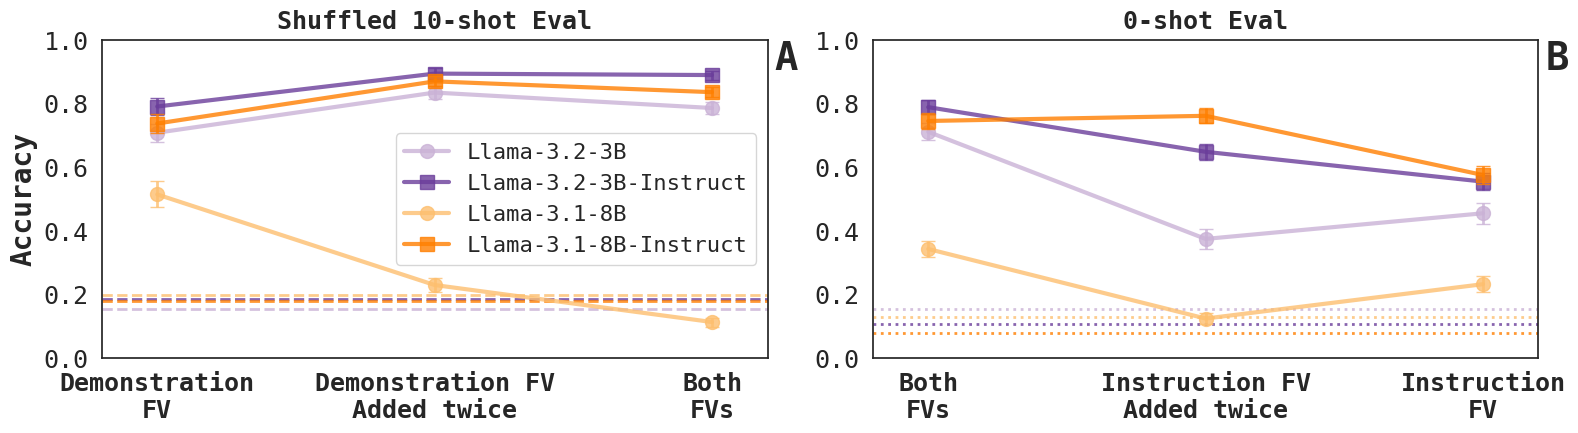

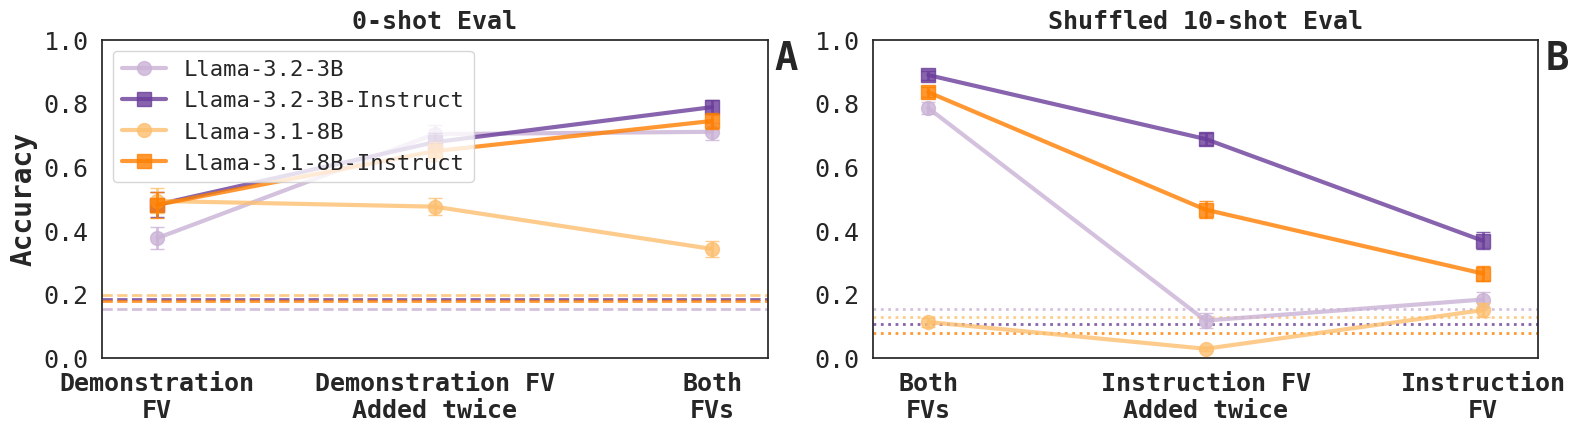

In [ ]:
matched_eval_cols_and_baselines = [
    [
        (
            [
                "ICL FV shuffled 10-shot (20 heads)",
                "ICL FV twice FV shuffled 10-shot (20 heads)",
                "Joint FV shuffled 10-shot (20 heads)",
            ],
            FEW_SHOT_SHUFFLED_BASELINE_METRICS,
        ),
    ],
    [
        (
            [
                "Joint FV 0-shot (20 heads)",
                "Prompt FV twice FV 0-shot (20 heads)",
                "Prompt FV 0-shot (20 heads)",
            ],
            ZERO_SHOT_BASELINE_METRICS,
        ),
    ],
]

unmatched_eval_cols_and_baselines = [
    [
        (
            [
                "ICL FV 0-shot (20 heads)",
                "ICL FV twice FV 0-shot (20 heads)",
                "Joint FV 0-shot (20 heads)",
            ],
            FEW_SHOT_SHUFFLED_BASELINE_METRICS,
        ),
    ],
    [
        (
            [
                "Joint FV shuffled 10-shot (20 heads)",
                "Prompt FV twice FV shuffled 10-shot (20 heads)",
                "Prompt FV shuffled 10-shot (20 heads)",
            ],
            ZERO_SHOT_BASELINE_METRICS,
        ),
    ],
]


for f, (figure_suffix, metric_and_baseline_names) in enumerate(
    (
        ("matched_evals", matched_eval_cols_and_baselines),
        ("unmatched_evals", unmatched_eval_cols_and_baselines),
    )
):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4.5))

    if USE_ONE_THIRD_LAYER:
        legend_loc = "center right" if figure_suffix == "matched_evals" else "upper left"
    else:
        legend_loc = "lower right" if figure_suffix == "matched_evals" else "lower right"

    for i, ax_metric_and_baseline_names in enumerate(metric_and_baseline_names):
        plot_connected_scatter(
            combined_model_dicts,
            MAIN_PLOT_MODELS,
            metric_and_baseline_names=ax_metric_and_baseline_names,
            metric_group_names=METRIC_GROUP_NAMES[i],
            metric_labels={
                "ICL FV shuffled 10-shot (20 heads)": "Demonstration\nFV",
                "Prompt FV shuffled 10-shot (20 heads)": "Instruction\nFV",
                "ICL FV 0-shot (20 heads)": "Demonstration\nFV",
                "Prompt FV 0-shot (20 heads)": "Instruction\nFV",
                "ICL activations FV 0-shot (20 heads)": "Inst heads\nDemo acts",
                "ICL top heads FV 0-shot (20 heads)": "Demo heads\nInst acts",
                "ICL activations FV shuffled 10-shot (20 heads)": "Inst heads\nDemo acts",
                "ICL top heads FV shuffled 10-shot (20 heads)": "Demo heads\nInst acts",
                # "Joint FV 0-shot (20 heads)": "Both FVs",
                # "Joint FV shuffled 10-shot (20 heads)": "Both FVs",
            },
            fontsize=20,
            fontfamily="monospace",
            font_inc=0,
            width=10,
            height=4,
            legend_outside=False,
            legend_loc=legend_loc,
            legend_fontsize=16,
            yticks=np.linspace(0, 1, 6),
            # baseline_annotation_nudges={
            #     "10-shot": -0.05,
            #     "Shuffled 10-shot": -0.06,
            # },
            baseline_x_inside_increment=0.2,
            should_show=False,
            show_legend=i == 0,
            ylabel="Accuracy" if i == 0 else "",
            ax=axes[i],
            annotate_panel=chr(ord("A") + i),
        )

    plt.tight_layout()
    save_plot(f"appendix_finding_2_fv_twice_control_{figure_suffix}_{LAYER_PLOT_SUFFIX}.pdf")
    plt.show()


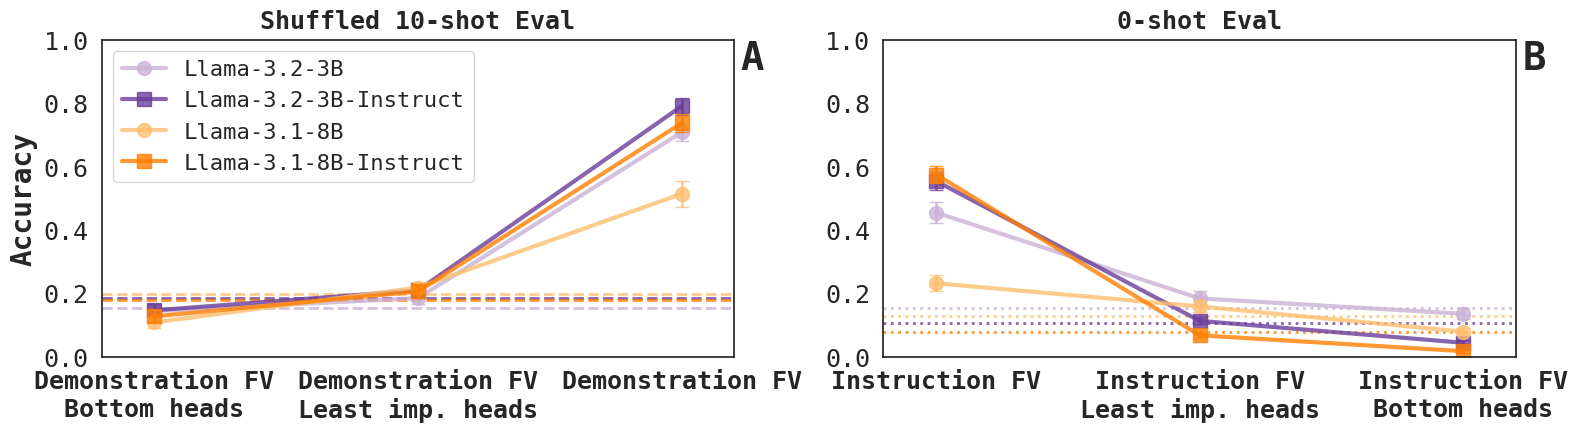

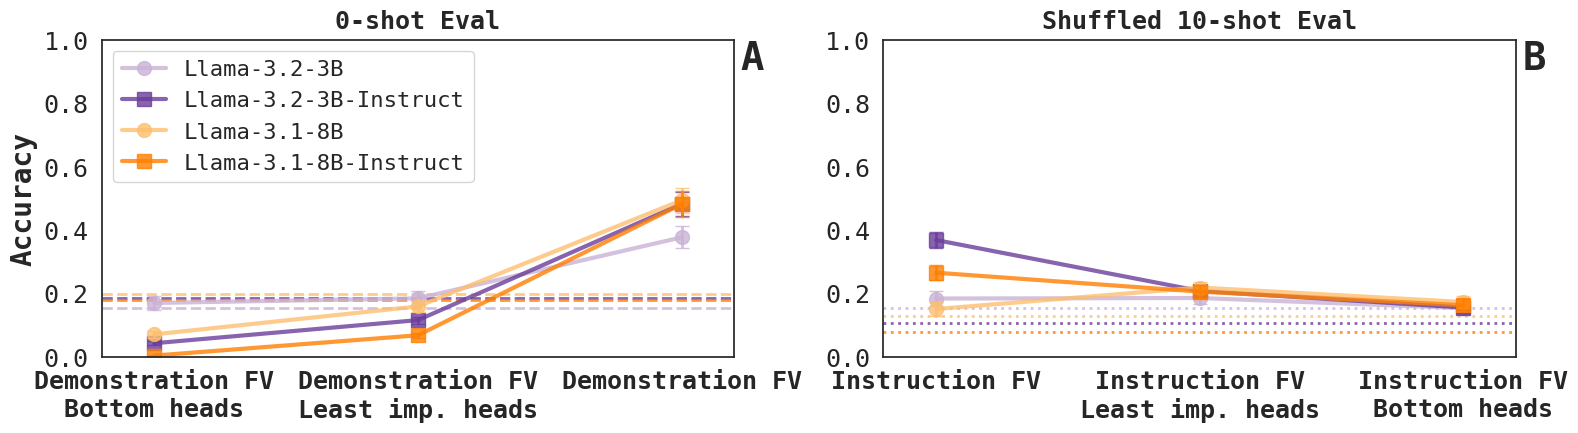

In [8]:
from palettable.colorbrewer.qualitative import Paired_12 as cmap

matched_eval_cols_and_baselines = [
    [
        (
            [
                "ICL bottom heads FV shuffled 10-shot (20 heads)",
                "ICL least imp heads FV shuffled 10-shot (20 heads)",
                "ICL FV shuffled 10-shot (20 heads)",
            ],
            FEW_SHOT_SHUFFLED_BASELINE_METRICS,
        ),
    ],
    [
        (
            [
                "Prompt FV 0-shot (20 heads)",
                "Prompt least imp heads FV 0-shot (20 heads)",
                "Prompt bottom heads FV 0-shot (20 heads)",
            ],
            ZERO_SHOT_BASELINE_METRICS,
        ),
    ],
]

unmatched_eval_cols_and_baselines = [
    [
        (
            [
                "ICL bottom heads FV 0-shot (20 heads)",
                "ICL least imp heads FV 0-shot (20 heads)",
                "ICL FV 0-shot (20 heads)",
            ],
            FEW_SHOT_SHUFFLED_BASELINE_METRICS,
        ),
    ],
    [
        (
            [
                "Prompt FV shuffled 10-shot (20 heads)",
                "Prompt least imp heads FV shuffled 10-shot (20 heads)",
                "Prompt bottom heads FV shuffled 10-shot (20 heads)",
            ],
            ZERO_SHOT_BASELINE_METRICS,
        ),
    ],
]


for f, (figure_suffix, metric_and_baseline_names) in enumerate(
    (
        ("matched_evals", matched_eval_cols_and_baselines),
        ("unmatched_evals", unmatched_eval_cols_and_baselines),
    )
):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4.5))

    for i, ax_metric_and_baseline_names in enumerate(metric_and_baseline_names):
        plot_connected_scatter(
            combined_model_dicts,
            MAIN_PLOT_MODELS,
            metric_and_baseline_names=ax_metric_and_baseline_names,
            metric_group_names=METRIC_GROUP_NAMES[i],
            fontsize=20,
            fontfamily="monospace",
            font_inc=0,
            width=10,
            height=4,
            legend_outside=False,
            legend_loc="upper left",  # (0.05, 0.4),  # (0.025, 0.75) if f == 0 else (0.55, 0.5),
            legend_fontsize=16,
            yticks=np.linspace(0, 1, 6),
            # baseline_annotation_nudges={
            #     "10-shot": -0.05,
            #     "Shuffled 10-shot": -0.06,
            # },
            baseline_x_inside_increment=0.2,
            should_show=False,
            show_legend=i == 0,
            ylabel="Accuracy" if i == 0 else "",
            ax=axes[i],
            annotate_panel=chr(ord("A") + i),
        )

    plt.tight_layout()
    save_plot(f"appendix_finding_4_least_imp_bottom_control_{figure_suffix}_{LAYER_PLOT_SUFFIX}.pdf")
    plt.show()


In [ ]:
# from palettable.colorbrewer.qualitative import Paired_12 as cmap

# summary_metric_cols = [
#     "ICL bottom heads FV 0-shot (20 heads)",
#     "ICL FV 0-shot (20 heads)",
#     "Joint FV 0-shot (20 heads)",
#     "Prompt FV 0-shot (20 heads)",
#     "Prompt bottom heads FV 0-shot (20 heads)",
# ]

# summary_baseline_cols = [
#     "Top-5 prompts (mean)",
#     "0-shot",
# ]

# few_shot_metric_cols = [
#     "ICL bottom heads FV shuffled 10-shot (20 heads)",
#     "ICL FV shuffled 10-shot (20 heads)",
#     "Joint FV shuffled 10-shot (20 heads)",
#     "Prompt FV shuffled 10-shot (20 heads)",
#     "Prompt bottom heads FV shuffled 10-shot (20 heads)",
# ]

# few_shot_baseline_cols = [
#     "10-shot",
#     "Shuffled 10-shot",
# ]

# metric_labels = {
#     "Top-5 prompts (mean)": "Instructed\n0-shot",
#     "0-shot": "0-shot",
#     "ICL FV 0-shot (20 heads)": "0-shot\nDemonstration FV",
#     "Prompt FV 0-shot (20 heads)": "0-shot\nInstruction FV",
#     "Joint FV 0-shot (20 heads)": "0-shot\nBoth FVs",
#     #
#     "10-shot": "10-shot",
#     "Shuffled 10-shot": "Shuffled\n10-shot",
#     "ICL FV shuffled 10-shot (20 heads)": "Shuffled 10-shot\nDemonstration FV",
#     "Prompt FV shuffled 10-shot (20 heads)": "Shuffled 10-shot\nInstruction FV",
#     "Joint FV shuffled 10-shot (20 heads)": "Shuffled 10-shot\nBoth FVs",
#     #
#     "ICL activations FV 0-shot (20 heads)": "0-shot\nDemonstration heads\nInstruction values",
#     "ICL top heads FV 0-shot (20 heads)": "0-shot\nInstruction heads\nDemonstration values",
#     "ICL activations FV shuffled 10-shot (20 heads)": "Shuffled 10-shot\nDemonstration heads\nInstruction values",
#     "ICL top heads FV shuffled 10-shot (20 heads)": "Shuffled 10-shot\nInstruction heads\nDemonstration values",
#     #
#     "Prompt FV twice FV 0-shot (20 heads)": "0-shot\nInstruction FV\nAdded twice",
#     "ICL FV twice FV 0-shot (20 heads)": "0-shot\nDemonstration FV\nAdded twice",
#     "Prompt FV twice FV shuffled 10-shot (20 heads)": "Shuffled 10-shot\nInstruction FV\nAdded twice",
#     "ICL FV twice FV shuffled 10-shot (20 heads)": "Shuffled 10-shot\nDemonstration FV\nAdded twice",
#     #
#     "ICL least imp heads FV 0-shot (20 heads)": "0-shot\nDemonstration FV\nLeast important heads",
#     "Prompt least imp heads FV 0-shot (20 heads)": "0-shot\nInstruction FV\nLeast important heads",
#     "ICL least imp heads FV shuffled 10-shot (20 heads)": "Shuffled 10-shot\nDemonstration FV\nLeast important heads",
#     "Prompt least imp heads FV shuffled 10-shot (20 heads)": "Shuffled 10-shot\nInstruction FV\nLeast important heads",
#     #
#     "ICL bottom heads FV 0-shot (20 heads)": "0-shot\nDemonstration FV\nBottom heads",
#     "Prompt bottom heads FV 0-shot (20 heads)": "0-shot\nInstruction FV\nBottom heads",
#     "ICL bottom heads FV shuffled 10-shot (20 heads)": "Shuffled 10-shot\nDemonstration FV\nBottom heads",
#     "Prompt bottom heads FV shuffled 10-shot (20 heads)": "Shuffled 10-shot\nInstruction FV\nBottom heads",
# }


# fig, axes = plt.subplots(1, 2, figsize=(20, 6))


# for i, (model_dicts, metric_names, baseline_metric_names) in enumerate(
#     (
#         (localizers_controls_zero_shot_model_dicts, summary_metric_cols, summary_baseline_cols),
#         (localizers_controls_shuffled_ten_shot_model_dicts, few_shot_metric_cols, few_shot_baseline_cols),
#     )
# ):
#     plot_connected_scatter(
#         model_dicts,
#         ["Llama-3.2-3B", "Llama-3.2-3B-Instruct", "Llama-3.1-8B", "Llama-3.1-8B-Instruct"],
#         metric_names=metric_names,
#         baseline_metric_names=baseline_metric_names,
#         model_plot_styles={
#             "Llama-3.2-3B": {"marker": "o", "color": cmap.mpl_colors[0]},
#             "Llama-3.2-3B-Instruct": {"marker": "s", "color": cmap.mpl_colors[1]},
#             "Llama-3.1-8B": {"marker": "o", "color": cmap.mpl_colors[6]},
#             "Llama-3.1-8B-Instruct": {"marker": "s", "color": cmap.mpl_colors[7]},
#         },
#         metric_plot_styles={
#             "0-shot": {"linestyle": ":", "linewidth": 2},
#             "Top-5 prompts (mean)": {"linestyle": "--", "linewidth": 2},
#             "Shuffled 10-shot": {"linestyle": ":", "linewidth": 2},
#             "10-shot": {"linestyle": "--", "linewidth": 2},
#         },
#         global_plot_style={
#             "markersize": 10,
#             "linewidth": 3,
#         },
#         metric_labels=metric_labels,
#         fontsize=14,
#         fontfamily="monospace",
#         font_inc=0,
#         width=6,
#         height=6,
#         legend_outside=False,
#         legend_loc=(0.35, 0.025),
#         legend_fontsize=12,
#         show_legend=i == 0,
#         ylabel="Accuracy" if i == 0 else "",
#         ax=axes[i],
#         annotate_panel=chr(ord("A") + i),
#         annotate_font_inc=16,
#     )

# plt.tight_layout()
# save_plot(f"appendix_rq2_3_bottom_heads_{LAYER_PLOT_SUFFIX}.pdf")
# plt.show()


# Older Plots


In [ ]:
summary_cols_nice_names = [
    "10-shot",
    "Top-5 prompts (mean)",
    "0-shot",
    "ICL FV 0-shot (10 heads)",
    "Prompt FV 0-shot (10 heads)",
    "Joint FV 0-shot (10 heads)",
    "ICL FV twice FV 0-shot (10 heads)",
    "Prompt FV twice FV 0-shot (10 heads)",
    "ICL activations FV 0-shot (10 heads)",
    "ICL top heads FV 0-shot (10 heads)",
    "ICL least imp heads FV 0-shot (10 heads)",
    "Prompt least imp heads FV 0-shot (10 heads)",
    "ICL bottom heads FV 0-shot (10 heads)",
    "Prompt bottom heads FV 0-shot (10 heads)",
]

metric_labels = [
    "ICL baseline (10-shot)",
    "Prompt baseline (Top-5 prompts)",
    "0-shot",
    "0-shot + ICL FV (10 heads)",
    "0-shot + Prompt FV (10)",
    "0-shot + Joint FV (10)",
    "0-shot + ICL FV x 2 (10 heads)",
    "0-shot + Prompt FV x 2 (10)",
    "0-shot + ICL acts / prompt top heads (10)",
    "0-shot + ICL top heads / prompt acts (10)",
    "0-shot + least imp heads / ICL acts (10 heads)",
    "0-shot + least imp heads / prompt acts (10 heads)",
    "0-shot + ICL bottom heads FV (10 heads)",
    "0-shot + Prompt bottom heads FV (10 heads)",
]

summary_cols_nice_names_20_heads = [c.replace("(10 heads)", "(20 heads)") for c in summary_cols_nice_names]

metric_labels_20_heads = [c.replace("(10 heads)", "(20 heads)").replace("(10)", "(20)") for c in metric_labels]


ordered_color_indices = [10, 11, 3, 2, 9, 8, 1, 0, 7, 6, 5, 4]

colors = [cmap.mpl_colors[i] for i in ordered_color_indices]
colors.insert(0, (0.8, 0.8, 0.8))
colors.insert(5, (1, 0.843, 0))


for i in range(len(RELEVANT_MODELS)):
    plot_metric_grouped_bar_chart(
        localizers_controls_zero_shot_model_dicts,
        [RELEVANT_MODELS[i]],
        summary_cols_nice_names,
        colors=colors,
        metric_labels=metric_labels,
        title=RELEVANT_MODELS[i] + " | 0-shot | 10 heads",
    )

    plot_metric_grouped_bar_chart(
        localizers_controls_zero_shot_model_dicts,
        [RELEVANT_MODELS[i]],
        summary_cols_nice_names_20_heads,
        colors=colors,
        metric_labels=metric_labels_20_heads,
        title=RELEVANT_MODELS[i] + " | 0-shot | 20 heads",
    )


In [ ]:
summary_cols_nice_names = [
    "10-shot",
    "Top-5 prompts (mean)",
    "Shuffled 10-shot",
    "ICL FV shuffled 10-shot (10 heads)",
    "Prompt FV shuffled 10-shot (10 heads)",
    "Joint FV shuffled 10-shot (10 heads)",
    "ICL FV twice FV shuffled 10-shot (10 heads)",
    "Prompt FV twice FV shuffled 10-shot (10 heads)",
    "ICL activations FV shuffled 10-shot (10 heads)",
    "ICL top heads FV shuffled 10-shot (10 heads)",
    "ICL least imp heads FV shuffled 10-shot (10 heads)",
    "Prompt least imp heads FV shuffled 10-shot (10 heads)",
    "ICL bottom heads FV shuffled 10-shot (10 heads)",
    "Prompt bottom heads FV shuffled 10-shot (10 heads)",
]

metric_labels = [
    "ICL baseline (10-shot)",
    "Prompt baseline (Top-5 prompts)",
    "S 10-shot",
    "S 10-shot + ICL FV",
    "S 10-shot + Prompt FV",
    "S 10-shot + Joint FV",
    "S 10-shot + ICL FV x 2",
    "S 10-shot + Prompt FV x 2",
    "S 10-shot + ICL acts / prompt top heads",
    "S 10-shot + ICL top heads / prompt acts",
    "S 10-shot + least imp heads / ICL acts",
    "S 10-shot + least imp heads / prompt acts",
    "S 10-shot + ICL bottom heads FV",
    "S 10-shot + Prompt bottom heads FV",
]

summary_cols_nice_names_20_heads = [c.replace("(10 heads)", "(20 heads)") for c in summary_cols_nice_names]

metric_labels_20_heads = [c.replace("(10 heads)", "(20 heads)").replace("(10)", "(20)") for c in metric_labels]


ordered_color_indices = [10, 11, 3, 2, 9, 8, 1, 0, 7, 6, 5, 4]

colors = [cmap.mpl_colors[i] for i in ordered_color_indices]
colors.insert(0, (0.8, 0.8, 0.8))
colors.insert(5, (1, 0.843, 0))


for i in range(len(RELEVANT_MODELS)):
    plot_metric_grouped_bar_chart(
        localizers_controls_shuffled_ten_shot_model_dicts,
        [RELEVANT_MODELS[i]],
        summary_cols_nice_names,
        colors=colors,
        metric_labels=metric_labels,
        title=RELEVANT_MODELS[i] + " | shuffled 10-shot | 10 heads",
    )

    plot_metric_grouped_bar_chart(
        localizers_controls_shuffled_ten_shot_model_dicts,
        [RELEVANT_MODELS[i]],
        summary_cols_nice_names_20_heads,
        colors=colors,
        metric_labels=metric_labels_20_heads,
        title=RELEVANT_MODELS[i] + " | shuffled 10-shot | 20 heads",
    )
